# Continous Model Monitoring with Vertex AI Endpoint logging
<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1q5_Iv7jbq_Oc-2zXlM5xfu5p9a89Y1NV#scrollTo=ndfGn8c4bI_G">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://storage.googleapis.com/cmm-public-data/notebooks/Continous_Model_Monitoring_with_Vertex_AI_Endpoint_logging.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo">Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Step 1: Authentication

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Colab, run:**

In [1]:
# from google.colab import auth
# auth.authenticate_user()


**3. Local JupyterLab instance, uncomment and run:**

In [2]:
# ! gcloud auth login

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

## Step 2: Installations & Setup
### Install the following packages to execute this notebook.

In [3]:
# ! pip3 install --upgrade --quiet \
#     google-cloud-aiplatform \
#     google-cloud-bigquery \
#     pandas-gbq \
#     'tensorflow_data_validation[visualization]<2'

# pip install --upgrade --force-reinstall google-cloud-aiplatform --user
# pip install --upgrade --force-reinstall google-cloud-bigquery --user
# pip install --upgrade --force-reinstall pandas-gbq --user
# pip install --upgrade --force-reinstall 'tensorflow_data_validation[visualization]<2' --user

In [4]:
# Model Monitoring Experimental SDK
# ! gsutil cp gs://cmm-public-data/sdk/google_cloud_aiplatform-1.36.dev20231025+centralized.model.monitoring-py2.py3-none-any.whl .
# ! pip install --quiet google_cloud_aiplatform-1.36.dev20231025+centralized.model.monitoring-py2.py3-none-any.whl --user

In [5]:
# pip install --upgrade --force-reinstall google_cloud_aiplatform-1.36.dev20231025+centralized.model.monitoring-py2.py3-none-any.whl --user

### Restart the kernel (only for Colab)

In [7]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Setup GCP Project ID and Initialize Vertex AI SDK for Python

In [8]:
import os

PROJECT_ID = "hybrid-vertex"

# set the project id
! gcloud config set project $PROJECT_ID
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

REGION = "us-central1"
! gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


In [37]:
# Initialize Vertex AI SDK for Python
import google.cloud.aiplatform as aiplatform
from google.cloud import bigquery

aiplatform.init(project=PROJECT_ID, location=REGION)

bq_client = bigquery.Client(project=PROJECT_ID)

In [10]:
CREATE_NEW_ASSETS = False

VERSION = "v2"
EXPERIMENT_NAME = f"vmm-test-mars-{VERSION}"

print(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")

EXPERIMENT_NAME: vmm-test-mars-v2


### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [11]:
BUCKET_URI = f"gs://a-{EXPERIMENT_NAME}-{PROJECT_ID}"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [12]:
if CREATE_NEW_ASSETS:
    ! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

## Step 3: Prepare a Model in Vertex AI Model Registry

In [13]:
import google.cloud.aiplatform as aiplatform

MODEL_PATH = "gs://mco-mm/churn"
MODEL_NAME = "churn"
IMAGE = "us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-5:latest"

In [14]:
if CREATE_NEW_ASSETS == True:
    # here
    model = aiplatform.Model.upload(
        display_name=MODEL_NAME,
        artifact_uri=MODEL_PATH,
        serving_container_image_uri=IMAGE,
        # explanation_parameters=EXPLAIN_PARAMS,
        # explanation_metadata=EXPLAIN_META,
        sync=True,
    )
else:
    # use existing
    model = aiplatform.Model('projects/934903580331/locations/us-central1/models/217982578253103104@1')

MODEL_ID = model.resource_name.split("/")[-1]

print(f"MODEL_ID: {MODEL_ID}")

MODEL_ID: 217982578253103104


## Step 4: Deploy Model to Vertex AI Endpoint with Req-Resp Logging Enabled

### Create an endpoint with logging enabled and deploy the model to this endpoint

In [15]:
# Create an endpoint with logging enabled. Specify the logging sampling rate and BigQuery Destination.
import pandas as pd

TIMESTAMP = pd.Timestamp.utcnow().strftime('%Y%m%d%H%M%S')
ENDPOINT_DISPLAY_NAME=f"churn_endpoint_{TIMESTAMP}"
BQ_LOGGING_DATASET=f"churn_production_{TIMESTAMP}"
BQ_LOGGING_TABLE=f"bq://{PROJECT_ID}.{BQ_LOGGING_DATASET}.req_resp"

print(f"ENDPOINT_DISPLAY_NAME : {ENDPOINT_DISPLAY_NAME}")
print(f"BQ_LOGGING_TABLE      : {BQ_LOGGING_TABLE}")

ENDPOINT_DISPLAY_NAME : churn_endpoint_20240103025557
BQ_LOGGING_TABLE      : bq://hybrid-vertex.churn_production_20240103025557.req_resp


In [16]:
if CREATE_NEW_ASSETS == True:
    # here
    endpoint = aiplatform.Endpoint.create(
        display_name=ENDPOINT_DISPLAY_NAME,
        enable_request_response_logging=True,
        request_response_logging_sampling_rate=1.0,
        request_response_logging_bq_destination_table=BQ_LOGGING_TABLE
    )
    # Deploy model to this endpoint
    endpoint.deploy(
        model=model,
        traffic_percentage=100,
        min_replica_count=1,
        max_replica_count=1,
        machine_type="n1-standard-4"
    )
else:
    # use existing
    endpoint = aiplatform.Endpoint('projects/934903580331/locations/us-central1/endpoints/8889764815824748544')

print(f"display_name : {endpoint.display_name}\n")
print(f"endpoint     : {endpoint}")

display_name : churn_endpoint_20240103020250

endpoint     : <google.cloud.aiplatform.models.Endpoint object at 0x7faa83833490> 
resource name: projects/934903580331/locations/us-central1/endpoints/8889764815824748544


### Run a prediction test

In [17]:
DEFAULT_INPUT = {
    "cnt_ad_reward": 0,
    "cnt_challenge_a_friend": 0,
    "cnt_completed_5_levels": 1,
    "cnt_level_complete_quickplay": 3,
    "cnt_level_end_quickplay": 5,
    "cnt_level_reset_quickplay": 2,
    "cnt_level_start_quickplay": 6,
    "cnt_post_score": 34,
    "cnt_spend_virtual_currency": 0,
    "cnt_use_extra_steps": 0,
    "cnt_user_engagement": 120,
    "country": "Denmark",
    "dayofweek": 3,
    "julianday": 254,
    "language": "da-dk",
    "month": 9,
    "operating_system": "IOS",
    "user_pseudo_id": "104B0770BAE16E8B53DF330C95881893",
}

1 0.870577692165845
0 0.129422307834155
Prediction(predictions=[{'churned_probs': [0.870577692165845, 0.129422307834155], 'predicted_churned': ['1'], 'churned_values': ['1', '0']}], deployed_model_id='5177140659336773632', model_version_id='1', model_resource_name='projects/934903580331/locations/us-central1/models/217982578253103104', explanations=None)


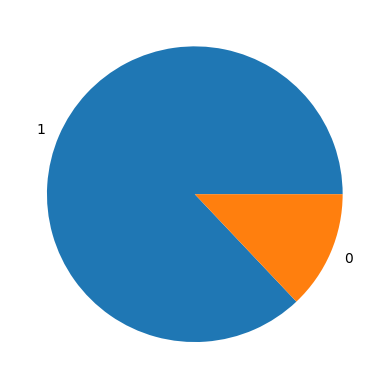

In [18]:
import matplotlib.pyplot as plt
import pprint as pp

try:
    resp = endpoint.predict([DEFAULT_INPUT])
    for i in resp.predictions:
        vals = i["churned_values"]
        probs = i["churned_probs"]
    for i in range(len(vals)):
        print(vals[i], probs[i])
    plt.pie(probs, labels=vals)
    pp.pprint(resp)
except Exception as ex:
    print("prediction request failed", ex)

### Send some prediction request to the endpoint

In [19]:
from google.cloud import bigquery
import time
import sys

# Here we just use subset of the training dataset as prediction data
DATASET_BQ_URI="bq://mco-mm.bqmlga4.train"
GROUND_TRUTH="churned"

bqclient = bigquery.Client(project=PROJECT_ID)
table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])

In [20]:
rows = bqclient.list_rows(table, max_results=1000)

count = 0
for row in rows:
    instance = {}
    for key, value in row.items():
        if key == GROUND_TRUTH:
            continue
        if value is None:
            value = ""
        instance[key] = value
    endpoint.predict(instances=[instance])
    # Print progress
    if count % 100 == 0:
      print(f"Sent: {count} requests")
    count = count + 1
    time.sleep(0.01)

Sent: 0 requests
Sent: 100 requests
Sent: 200 requests
Sent: 300 requests
Sent: 400 requests
Sent: 500 requests
Sent: 600 requests
Sent: 700 requests
Sent: 800 requests
Sent: 900 requests


Check the endpoint logging table.

In [21]:
# tmp-jt 
# BQ_LOGGING_TABLE = "bq://hybrid-vertex.churn_production_20240103020250.req_resp"

In [58]:
import pandas as pd

query_string = f"SELECT * FROM `{BQ_LOGGING_TABLE[5:]}` ORDER BY logging_time DESC LIMIT 5"
pd.read_gbq(query_string, project_id=PROJECT_ID)

,endpoint,deployed_model_id,logging_time,request_id,request_payload,response_payload
0,projects/934903580331/locations/us-central1/en...,5177140659336773632,2024-01-03 03:47:47.928883+00:00,1342843371185681229.000000000,"[{""dayofweek"":3,""cnt_level_reset_quickplay"":0,...","[{""churned_values"":[""1"",""0""],""predicted_churne..."
1,projects/934903580331/locations/us-central1/en...,5177140659336773632,2024-01-03 03:47:46.512121+00:00,8184157551987388455.000000000,"[{""cnt_use_extra_steps"":0,""language"":""en-us"",""...","[{""churned_values"":[""1"",""0""],""churned_probs"":[..."
2,projects/934903580331/locations/us-central1/en...,5177140659336773632,2024-01-03 03:47:45.244123+00:00,1652724713569221069.000000000,"[{""cnt_level_reset_quickplay"":0,""cnt_user_enga...","[{""predicted_churned"":[""1""],""churned_values"":[..."
3,projects/934903580331/locations/us-central1/en...,5177140659336773632,2024-01-03 03:47:44.079094+00:00,3152074806772958339.000000000,"[{""julianday"":163,""dayofweek"":3,""cnt_spend_vir...","[{""churned_values"":[""1"",""0""],""predicted_churne..."
4,projects/934903580331/locations/us-central1/en...,5177140659336773632,2024-01-03 03:47:42.765463+00:00,6578410890068812357.000000000,"[{""cnt_spend_virtual_currency"":0,""operating_sy...","[{""churned_probs"":[0.82404962551851546,0.17595..."


## Step 5: Create a Model Monitor

In [23]:
# !pip install --force-reinstall protobuf==3.20.0 --user

## tmp-jt: was protobuf==4.25.1

In [26]:
from google.cloud.aiplatform.private_preview.centralized_model_monitoring import model_monitor

MODEL_VERSION_ID = "1"

MM_VERSION = "v1"
MONITOR_DISPLAY_NAME=f"churn_model_monitor-{MM_VERSION}"

print(f"MONITOR_DISPLAY_NAME : {MONITOR_DISPLAY_NAME}")

MONITOR_DISPLAY_NAME : churn_model_monitor-v1


In [27]:
my_model_monitor = model_monitor.ModelMonitor.create(
    project=PROJECT_ID,
    location=REGION,
    display_name=MONITOR_DISPLAY_NAME,
    model_name=model.resource_name,
    model_version_id=MODEL_VERSION_ID
)

MODEL_MONITOR_RESOURCE_NAME = my_model_monitor.name
print(f"MODEL MONITOR {MODEL_MONITOR_RESOURCE_NAME} created.")

Creating ModelMonitor
Create ModelMonitor backing LRO: projects/934903580331/locations/us-central1/modelMonitors/3182496824179032064/operations/4233787101776183296
ModelMonitor created. Resource name: projects/934903580331/locations/us-central1/modelMonitors/3182496824179032064
To use this ModelMonitor in another session:
model_monitor = aiplatform.ModelMonitor('projects/934903580331/locations/us-central1/modelMonitors/3182496824179032064')
MODEL MONITOR 3182496824179032064 created.


## Step 6: Schedule Continous Model Monitoring

In [31]:
# feature_names
feature_names = [
      "cnt_ad_reward",
      # "cnt_challenge_a_friend",
      # "cnt_completed_5_levels",
      # "cnt_level_complete_quickplay",
      # "cnt_level_end_quickplay",
      # "cnt_level_reset_quickplay",
      "cnt_level_start_quickplay",
      "cnt_post_score",
      "cnt_spend_virtual_currency",
      "cnt_use_extra_steps",
      "cnt_user_engagement",
      "country",
      # "dayofweek",
      # "julianday",
      # "language",
      # "month",
      # "operating_system",
      # "user_pseudo_id",
]

DEFAULT_THRESHOLD_VALUE = 0.001
DRIFT_THRESHOLD_VALUE = 0.001
ATTRIBUTION_DRIFT_THRESHOLD_VALUE = 0.001

# =========================== #
##   Feature value drift     ##
# =========================== #
SKEW_THRESHOLDS = dict()

for feature in feature_names:
    if feature in SKEW_THRESHOLDS:
        print("feature name already in dict")
    else:
        SKEW_THRESHOLDS[feature] = DEFAULT_THRESHOLD_VALUE
        
print(f"SKEW_THRESHOLDS      : {SKEW_THRESHOLDS}\n")

SKEW_THRESHOLDS      : {'cnt_ad_reward': 0.001, 'cnt_level_start_quickplay': 0.001, 'cnt_post_score': 0.001, 'cnt_spend_virtual_currency': 0.001, 'cnt_use_extra_steps': 0.001, 'cnt_user_engagement': 0.001, 'country': 0.001}



In [32]:
# URI to training dataset.
DATASET_BQ_URI = "bq://mco-mm.bqmlga4.train"
# Prediction target column name in training dataset.
GROUND_TRUTH = "churned"

EMAIL = "jordantotten@google.com"  # @param {type:"string"}
CRON="20 * * * *" # @param {type:"string"} Every 1 hour at :00, for example 1:00, 2:00..
DATA_WINDOW="1h"
SCHEDULE_DISPLAY_NAME="churn-continous-skew-detection"

In [33]:
model_monitoring_schedule=my_model_monitor.create_schedule(
    display_name=SCHEDULE_DISPLAY_NAME,
    cron=CRON,
    objective_config=model_monitor.spec.ObjectiveSpec(
        baseline=model_monitor.spec.MonitoringInput(
            table_uri=DATASET_BQ_URI,
            ground_truth_field=GROUND_TRUTH
        ),
        target=model_monitor.spec.MonitoringInput(
            endpoints=[endpoint.resource_name]
        ),
        feature_distribution_skew=model_monitor.spec.SkewSpec(
            default_threshold=DEFAULT_THRESHOLD_VALUE,
            feature_thresholds=SKEW_THRESHOLDS,
            window=DATA_WINDOW
        ),
    ),
    notification_config=model_monitor.spec.NotificationSpec(
        user_emails=[EMAIL],
    ),
    output_config=model_monitor.spec.OutputSpec(
        gcs_base_dir=BUCKET_URI
    )
)

SCHEDULE_RESOURCE_NAME = model_monitoring_schedule.name
print(f"Schedule {SCHEDULE_RESOURCE_NAME} created.")

Schedule projects/934903580331/locations/us-central1/schedules/5015233174100246528 created.


## Step 7: Wait for the scheduled Model Monitoring Job to run and verify the result

Note: If no data is fetched in the model monitoring job, the job will still be marked as successful but no metrics are generated.
You could continously send more prediction traffic as Step 4 mentioned.

In [57]:
# List the jobs, you would a job if the scheduled one start to run.
# my_model_monitor.list_jobs()

### Simulate Endpoint traffic

In [42]:
DATASET_BQ_URI[5:]

'mco-mm.bqmlga4.train'

In [46]:
# Download the table.
table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])

# rows = bqclient.list_rows(table, max_results=2000)

TARGET = "churned"

In [59]:
print("Simulating Skewed Traffic...\n")

start=3
end=8

for multiplier in range(start, end+1):
    # test_time=1200
    # tests_per_second = 1
    # sleep_time = 1 / tests_per_second
    # iterations = test_time * tests_per_second
    
    rows = bqclient.list_rows(table, max_results=2000)
    
    # get instances
    print(f"prepping instances with multiplier: {multiplier} ...")
    instances = []
    for row in rows:
        instance = {}
        for key, value in row.items():
            if key == TARGET:
                continue
            if value is None:
                value = ""
            instance[key] = value
        instance['cnt_ad_reward'] = instance['cnt_ad_reward'] * multiplier
        instance['cnt_level_start_quickplay'] = instance['cnt_level_start_quickplay'] * multiplier
        instance['cnt_post_score'] = instance['cnt_post_score'] * multiplier
        instance['cnt_spend_virtual_currency'] = instance['cnt_spend_virtual_currency'] * multiplier
        instance['cnt_use_extra_steps'] = instance['cnt_use_extra_steps'] * multiplier
        instance['cnt_user_engagement'] = instance['cnt_user_engagement'] * multiplier
        instances.append(instance)
        
    # predict with instances
    print(f"Sending skewed traffic...")
    
    response = endpoint.predict(instances=instances)
    prediction = response[0]
    
    print(f"Prediction for the first instance: \n {prediction[0]} \n")

Simulating Skewed Traffic...

prepping instances with multiplier: 3 ...
Sending skewed traffic...
Prediction for the first instance: 
 {'churned_values': ['1', '0'], 'predicted_churned': ['1'], 'churned_probs': [0.6757116328584678, 0.3242883671415322]} 

prepping instances with multiplier: 4 ...
Sending skewed traffic...
Prediction for the first instance: 
 {'churned_probs': [0.8240496255185155, 0.1759503744814845], 'churned_values': ['1', '0'], 'predicted_churned': ['1']} 

prepping instances with multiplier: 5 ...
Sending skewed traffic...
Prediction for the first instance: 
 {'churned_probs': [0.9132456434282916, 0.08675435657170838], 'predicted_churned': ['1'], 'churned_values': ['1', '0']} 

prepping instances with multiplier: 6 ...
Sending skewed traffic...
Prediction for the first instance: 
 {'churned_values': ['1', '0'], 'churned_probs': [0.9594498183685726, 0.04055018163142743], 'predicted_churned': ['1']} 

prepping instances with multiplier: 7 ...
Sending skewed traffic...


In [54]:
instances[4]['cnt_user_engagement']

992

In [55]:
instances[0]

{'user_pseudo_id': '9245B5CB02DD3705AA94778F256D5A53',
 'country': 'United States',
 'operating_system': '',
 'language': 'en-us',
 'cnt_user_engagement': 6104,
 'cnt_level_start_quickplay': 2216,
 'cnt_level_end_quickplay': 273,
 'cnt_level_complete_quickplay': 143,
 'cnt_level_reset_quickplay': 0,
 'cnt_post_score': 1144,
 'cnt_spend_virtual_currency': 0,
 'cnt_ad_reward': 0,
 'cnt_challenge_a_friend': 0,
 'cnt_completed_5_levels': 0,
 'cnt_use_extra_steps': 0,
 'month': 6,
 'julianday': 163,
 'dayofweek': 3}

In [56]:
# List the jobs, you would a job if the scheduled one start to run.
my_model_monitor.list_jobs()

[name: "projects/934903580331/locations/us-central1/modelMonitors/3182496824179032064/modelMonitoringJobs/9059764706641707008"
display_name: "churn-continous-skew-detection-20240102192000000"
model_monitoring_spec {
  objective_spec {
    tabular_objective {
      baseline {
        columnized_dataset {
          ground_truth_field: "churned"
          bigquery_source {
            table_uri: "bq://mco-mm.bqmlga4.train"
          }
        }
      }
      target {
        vertex_endpoint_logs {
          endpoints: "projects/934903580331/locations/us-central1/endpoints/8889764815824748544"
        }
      }
      feature_distribution_skew {
        default_alert_condition {
          threshold: 0.001
        }
        alert_conditions {
          key: "cnt_ad_reward"
          value {
            threshold: 0.001
          }
        }
        alert_conditions {
          key: "cnt_level_start_quickplay"
          value {
            threshold: 0.001
          }
        }
        alert_

## Interpret results

### Check email

#### Here's a sample create job email...

<img src="https://services.google.com/fh/files/misc/job_create.png">

#### If there is any anomaly detected, you will receive an email like

<img src="https://services.google.com/fh/files/misc/alert_email.png" />

### Check GCP Console

#### Check the "Monitor" tab under "Vertex AI"

<img src="https://services.google.com/fh/files/misc/continous_gif.gif" />

### Verify Output GCS bucket after job is finished

In [ ]:
jobs=my_model_monitor.list_jobs()
jobs

Note: If there is no data fecthed in the job, there will no output metrics

In [ ]:
# Enter the interested job resource name.
CMM_JOB_RESOURCE_NAME="[job-resource-name]" # @param {type:"string"}
example_job=CMM_JOB_RESOURCE_NAME
if example_job == "[job-resource-name]" and len(jobs):
    example_job=jobs[0].name

print(f"Result for job {example_job}:")
my_model_monitor.show_skew_stats(model_monitoring_job_name=example_job)


## Step 8: Clean Up (after job finished)

In [ ]:
# from google.cloud import bigquery

# # When no jobs are running, delete the schedule and all the jobs.
# my_model_monitor.delete_schedule(SCHEDULE_RESOURCE_NAME)
# my_model_monitor.delete_all_model_monitoring_jobs()
# my_model_monitor.delete()

# # Undeploy the model and delete the endpoint
# endpoint.undeploy_all()
# endpoint.delete()

# # Delete the model
# model.delete()

# # Delete BQ logging table
# bqclient = bigquery.Client(project=PROJECT_ID)
# # Delete the dataset (including all tables)
# bqclient.delete_dataset(BQ_LOGGING_DATASET, delete_contents=True, not_found_ok=True)